# Evaluation of the DARTH approach

## Initialize the environment

In [1]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore

import matplotlib.pyplot as plt  # type: ignore
from matplotlib.ticker import MaxNLocator  # type: ignore

from sklearn.manifold import TSNE  # type: ignore
from sklearn.decomposition import PCA  # type: ignore
from sklearn.preprocessing import StandardScaler  # type: ignore

from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.linear_model import LinearRegression  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import json
import lightgbm as lgb

SEED = 42
s = 1000

def get_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target, ipi, mpi):
    return f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}_tr{r_target:.2f}_ipi{ipi}_mpi{mpi}.txt"


def get_detailed_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target, ipi, mpi):
    return f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/detailed/M{M}_efC{efC}_efS{efS}_qs{s}_tr{r_target:.2f}_ipi{ipi}_mpi{mpi}.txt"


def get_naive_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target, dt):
    return f"../../experiments/results/naive-early-stop-testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}_tr{r_target}_dt{dt}.txt"


def get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k):
    return f"../../experiments/results/no-early-stop/testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}.txt"


def get_laet_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target):
    return f"../../experiments/results/laet-early-stop-testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}_tr{r_target:.2f}.txt"


def get_optimal_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k):
    return f"../../experiments/results/no-early-stop/testing/{ds_name}/k{k}/detailed.M{M}_efC{efC}_efS{efS}_qs{s}.txt"


def get_heuristic_interval_conf_filename(version="v1"):
    return f"./heuristic_recommendations_params_{version}.json"


def get_testing_detailed_dataset_name(M, efC, efS, s, ds_name, k, logint): 
    return f"../../experiments/results/test_logging/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}_li{logint}.txt"


def get_model_name(M, ef, s, ds_name, k, logint, selected_features, n_estimators=100):
    return f"../../predictor_models/lightgbm/{ds_name}_M{M}_ef{ef}_s{s}_k{k}_nestim{n_estimators}_li{logint}_{selected_features}.txt"

def compute_P99(y_true, y_pred):
    y_diff = np.abs(y_true - y_pred)
    return np.percentile(y_diff, 99)

dataset_params = {
        "SIFT100M": {
            "M": 32,
            "efC": 500,
            "efS": 500,
            "color": "lightblue",
            "marker": "o",
            "li": 1,
            "label": "SIFT100M"
        },
        "DEEP100M": {
            "M": 32,
            "efC": 500,
            "efS": 750,
            "color": "plum",
            "marker": "x",   
            "li": 1,
            "label": "DEEP100M"
        },
        "T2I100M": {
            "M": 80,
            "efC": 1000,
            "efS": 2500,
            "color": "rosybrown",
            "marker": "d",
            "li": 2,
            "label": "T2I100M"
        },
        "GLOVE100": {
            "M": 16,
            "efC": 500,
            "efS": 500,
            "color": "orange",
            "marker": "^",
            "li": 1,
            "label": "GLOVE1M"
        },
        "GIST1M": {
            "M": 32,
            "efC": 500,
            "efS": 1000,
            "color": "lightgreen",
            "marker": "s",
            "li": 1,
            "label": "GIST1M"
        },
    }

# Load the dataconf from a file:
interval_conf = {}
with open("../../experiments/generated_json/final_heuristic_adaptive_recommendations_params_ipidiv2_mpidiv10.json") as f:
    interval_conf = json.load(f)

print(interval_conf.keys(), interval_conf["SIFT100M"].keys(), interval_conf["SIFT100M"]["100"].keys())

PLOTS_DIR = "./../../experiments/revision-plots/"

dict_keys(['T2I100M', 'SIFT100M', 'GLOVE100', 'GIST1M', 'DEEP100M']) dict_keys(['10', '25', '50', '75', '100']) dict_keys(['0.80', '0.85', '0.90', '0.95', '0.99'])


## Average Prediction Times in DARTH

In [2]:
all_datasets = ["T2I100M"]
all_k_values = ["10", "25", "50", "75", "100"]
all_r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]

average_prediction_times = []
for ds_name in all_datasets:
    M = dataset_params[ds_name]["M"]
    efC = dataset_params[ds_name]["efC"]
    efS = dataset_params[ds_name]["efS"]
    per_k_values = []
    for k in all_k_values:
        per_recall_values = []
        for r_target in all_r_targets:
            if ds_name == "T2I100M" and r_target == "0.99":
                continue
            
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
        
            darth_df = pd.read_csv(get_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, float(r_target), ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            average_per_prediction_times = darth_df["r_predictor_time_ms"] / darth_df["r_predictor_calls"]
            
            average_per_prediction_time = average_per_prediction_times.mean()
            per_recall_values.append(average_per_prediction_time)
        per_k_values.append(np.mean(per_recall_values))
    
    average_prediction_time_ds = np.mean(per_k_values)
    #print(f"Dataset: {ds_name}: {average_prediction_time_ds:.2f} ms")
    
    average_prediction_times.append(average_prediction_time_ds)

print(f"Average prediction time: {np.mean(average_prediction_times):.2f} ms")
        


Average prediction time: 0.03 ms


## ML Test Measures for the predictor

In [2]:
SEED = 42
n_estimators = 100

index_metric_feats = ["step", "dists", "inserts"]
neighbor_distances_feats = ["first_nn_dist", "nn_dist", "furthest_dist"]
neighbor_stats_feats = ["avg_dist", "variance", "percentile_25", "percentile_50", "percentile_75"]
all_feats = index_metric_feats + neighbor_distances_feats + neighbor_stats_feats

columns_to_load = ["qid", "elaps_ms"] + all_feats + ["r", "feats_collect_time_ms"]

feature_classes = {
    "index_metric_feats": index_metric_feats,
    "neighbor_distances_feats": neighbor_distances_feats,
    "neighbor_stats_feats": neighbor_stats_feats,
    "index_metrics_and_neighbor_distances": index_metric_feats + neighbor_distances_feats,
    "index_metrics_and_neighbor_stats": index_metric_feats + neighbor_stats_feats,
    "neighbor_distances_and_neighbor_stats": neighbor_distances_feats + neighbor_stats_feats,
    "all_feats": all_feats,
}


all_k_values = ["10", "25", "50", "75", "100"]
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]

for ds_name in all_datasets:
    mse_per_k = []
    mae_per_k = []
    r2_per_k = []
    p99_per_k = []
    max_error_per_k = []
    
    M = dataset_params[ds_name]["M"]
    efC = dataset_params[ds_name]["efC"]
    efS = dataset_params[ds_name]["efS"]
    
    for k in all_k_values:
        
        testing_data_df = pd.read_csv(get_testing_detailed_dataset_name(M, efC, efS, 1000, ds_name, k, 1), usecols=columns_to_load)
        testing_y_true = testing_data_df["r"]
                    
        feats = all_feats
        li = dataset_params[ds_name]["li"]
        model_file = f"../../predictor_models/darth/{ds_name}_M{M}_efC{efC}_efS{efS}_s{10000}_k{k}_nestim{n_estimators}_li{li}_all_feats.txt"
        model = lgb.Booster(model_file=model_file)
                    
        validation_X = testing_data_df[feats]
        validation_y_pred = model.predict(validation_X)
        mse = mean_squared_error(testing_y_true, validation_y_pred)
        mae = mean_absolute_error(testing_y_true, validation_y_pred)
        r2 = r2_score(testing_y_true, validation_y_pred)
        p99 = compute_P99(testing_y_true, validation_y_pred)
        max_error = np.max(np.abs(testing_y_true - validation_y_pred))
        
        mse_per_k.append(mse)
        mae_per_k.append(mae)
        r2_per_k.append(r2)
        p99_per_k.append(p99)
        max_error_per_k.append(max_error)
        
        #print(f"mse: {mse:.4f}, mae: {mae:.4f}, r2: {r2:.4f}, p99: {p99:.4f}")
        print(f"    {ds_name} k={k} => mse: {mse:.4f}, mae: {mae:.4f}, r2: {r2:.2f}, p99: {p99:.4f}, max_error: {max_error:.4f}")

    mse_ds = np.mean(mse_per_k)
    mae_ds = np.mean(mae_per_k)
    r2_ds = np.mean(r2_per_k)
    p99_ds = np.mean(p99_per_k)
    max_error_ds = np.mean(max_error_per_k)
    
    print(f"{ds_name} => mse: {mse_ds:.4f}, mae: {mae_ds:.4f}, r2: {r2_ds:.2f}, p99: {p99_ds:.4f}, max_error: {max_error_ds:.4f}")
                     

    SIFT100M k=10 => mse: 0.0044, mae: 0.0301, r2: 0.84, p99: 0.2911, max_error: 0.7824
    SIFT100M k=25 => mse: 0.0030, mae: 0.0285, r2: 0.89, p99: 0.2330, max_error: 0.5697
    SIFT100M k=50 => mse: 0.0025, mae: 0.0282, r2: 0.92, p99: 0.2014, max_error: 0.5172
    SIFT100M k=75 => mse: 0.0023, mae: 0.0278, r2: 0.93, p99: 0.1833, max_error: 0.4581
    SIFT100M k=100 => mse: 0.0021, mae: 0.0278, r2: 0.94, p99: 0.1717, max_error: 0.3996
SIFT100M => mse: 0.0029, mae: 0.0285, r2: 0.90, p99: 0.2161, max_error: 0.5454
    DEEP100M k=10 => mse: 0.0043, mae: 0.0290, r2: 0.80, p99: 0.2897, max_error: 0.9090
    DEEP100M k=25 => mse: 0.0030, mae: 0.0274, r2: 0.87, p99: 0.2350, max_error: 0.6579
    DEEP100M k=50 => mse: 0.0025, mae: 0.0268, r2: 0.90, p99: 0.2107, max_error: 0.5462
    DEEP100M k=75 => mse: 0.0022, mae: 0.0259, r2: 0.92, p99: 0.1940, max_error: 0.4539
    DEEP100M k=100 => mse: 0.0021, mae: 0.0260, r2: 0.92, p99: 0.1881, max_error: 0.4166
DEEP100M => mse: 0.0028, mae: 0.0270, r

## Summary of performance of DARTH approach

### Calculate all speedups and recall performance for all datasets

In [6]:
# Calculate for all datasets and all k-s the average recall vs the target recall
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["10", "25", "50", "75", "100"]
all_r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]

all_speedups = [] #meant to extract analytics

ds_recalls = {} # k -> dataset -> [recall, std, qut, speedup for each r_target]

for k in all_k_values:
    ds_recalls[k] = {}
    print(f"k: {k}")
    for ds_name in all_datasets:
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]
        print(f"    Dataset: {ds_name}")
        ds_recalls[k][ds_name] = []
        
        for r_target in all_r_targets:
            if ds_name == "T2I100M" and r_target == "0.99":
                ds_recalls[k][ds_name].append([])
                continue
            
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
            r_target = float(r_target)
                
            #print(f"r_target: {r_target}, ipi: {ipi}, mpi: {mpi}")
                
            no_early_termination_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
            darth_df = pd.read_csv(get_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target, ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            
            # Important:
            # For the given recall target, find which queries do not reach the target recall in general (from the no-early-termination runs)
            # Then, remove those queries from both the no-early-termination and the DARTH runs
            no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target]
            darth_df = darth_df[darth_df["qid"].isin(no_early_termination_df["qid"])]
            
            darth_recall_avg = darth_df["r_actual"].mean()
            darth_recall_std = darth_df["r_actual"].std()
            darth_df["r_actual"] = darth_df["r_actual"].apply(lambda x: round(x, 2))
            darth_rqut = len(darth_df[darth_df["r_actual"] < r_target])
            
            speedup = no_early_termination_df["elaps_ms"].mean() / darth_df["elaps_ms"].mean()
            
            per_query_speedups = no_early_termination_df["elaps_ms"] / darth_df["elaps_ms"]
            speedup_v2 = per_query_speedups.mean()
            
            all_speedups.append(speedup_v2)
            
            ds_recalls[k][ds_name].append([darth_recall_avg, darth_recall_std, darth_rqut, speedup, speedup_v2])
            
            print(f"        r_target: {r_target}, darth_recall_avg: {darth_recall_avg:.4f}, darth_recall_std: {darth_recall_std:.4f}, darth_rqut: {darth_rqut}, speedup_v2: {speedup_v2:.2f}x")            

#print(f"Overall average speedup: {overall_average_speedup / overall_average_speedup_times:.2f}x")
print(f"Overall average speedup: {np.mean(all_speedups):.2f}x")
print(f"Overall median speedup: {np.median(all_speedups):.2f}x")
print(f"Max speedup: {np.max(all_speedups):.2f}x")

k: 10
    Dataset: SIFT100M
        r_target: 0.8, darth_recall_avg: 0.8446, darth_recall_std: 0.1450, darth_rqut: 229, speedup_v2: 12.58x
        r_target: 0.85, darth_recall_avg: 0.8833, darth_recall_std: 0.1225, darth_rqut: 324, speedup_v2: 10.72x
        r_target: 0.9, darth_recall_avg: 0.9257, darth_recall_std: 0.1003, darth_rqut: 185, speedup_v2: 8.47x
        r_target: 0.95, darth_recall_avg: 0.9636, darth_recall_std: 0.0681, darth_rqut: 276, speedup_v2: 6.16x
        r_target: 0.99, darth_recall_avg: 0.9938, darth_recall_std: 0.0254, darth_rqut: 59, speedup_v2: 3.17x
    Dataset: DEEP100M
        r_target: 0.8, darth_recall_avg: 0.8581, darth_recall_std: 0.1556, darth_rqut: 217, speedup_v2: 19.60x
        r_target: 0.85, darth_recall_avg: 0.8938, darth_recall_std: 0.1333, darth_rqut: 283, speedup_v2: 16.50x
        r_target: 0.9, darth_recall_avg: 0.9332, darth_recall_std: 0.1025, darth_rqut: 156, speedup_v2: 11.92x
        r_target: 0.95, darth_recall_avg: 0.9658, darth_recall

### Generate the plots for all normal datasets (except T2I100M)

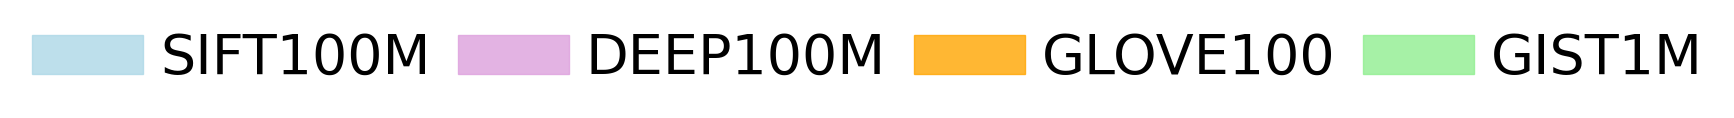

Fig saved at ./../../experiments/revision-plots/summary_recall_vs_target_recall_k50.pdf


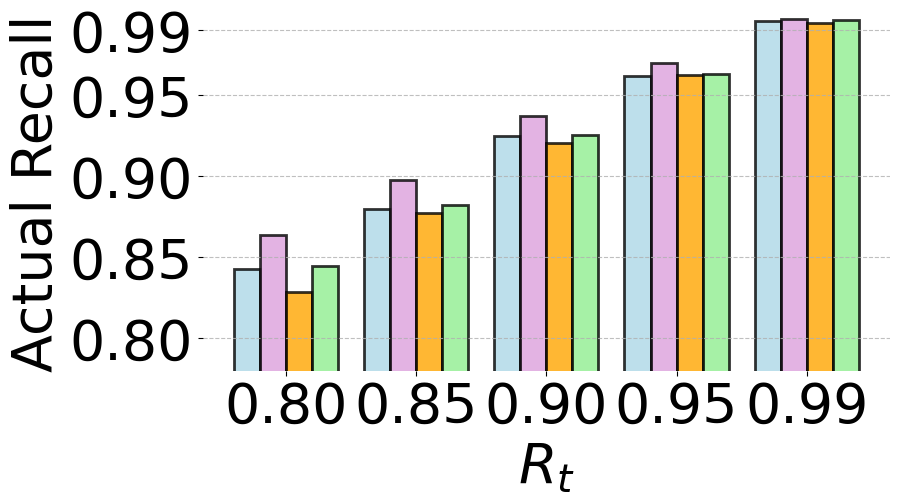

Fig saved at ./../../experiments/revision-plots/summary_speedup_vs_target_recall_k50.pdf


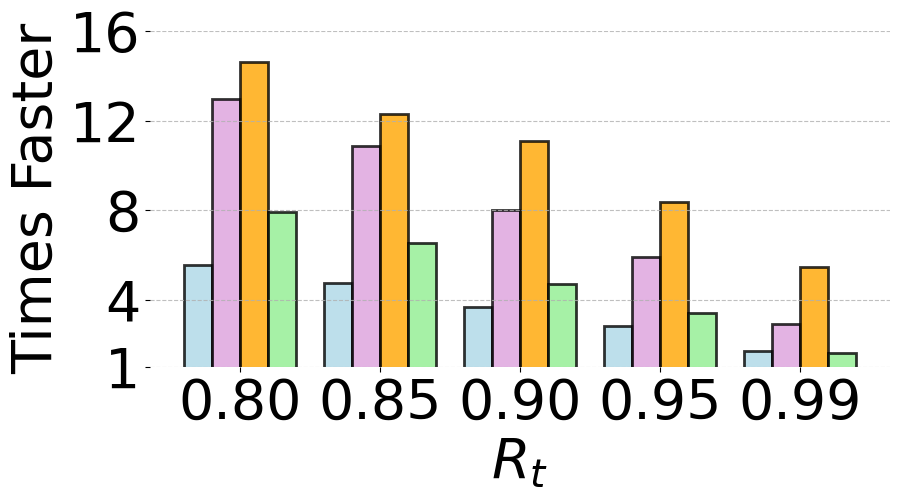

In [7]:
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]
all_r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]

plt.rcParams.update({"font.size": 40})

fig_legend, ax_legend = plt.subplots(figsize=(8, 1))
legend_elements = [Patch(facecolor=dataset_params[ds_name]["color"], edgecolor=dataset_params[ds_name]["color"], alpha=0.8, label=ds_name) for ds_name in ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]]
ax_legend.legend(handles=legend_elements, loc='center', ncol=4, frameon=False, handletextpad=0.3,  columnspacing=0.5, labelspacing=0.3 )
ax_legend.axis('off')
fig_legend.savefig(f"{PLOTS_DIR}summary_speedups_legend_only.pdf", bbox_inches="tight")
plt.show()
plt.close(fig_legend)

for k in all_k_values:
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    x = np.arange(len(all_r_targets))
    for i, ds_name in enumerate(all_datasets):
        recalls = []
        x_positions = x + i * bar_width

        for j, r_target in enumerate(all_r_targets):
            recall = ds_recalls[k][ds_name][j][0]
            recall_std = ds_recalls[k][ds_name][j][1]
            recalls.append(recall)
            std = recall_std
            ax.bar(x_positions[j], recall, bar_width, color=dataset_params[ds_name]["color"], alpha=0.8, edgecolor='black', linewidth=2)
            
    ax.set_xticks(x + (len(all_datasets) - 1) * bar_width / 2)
    ax.set_yticks([float(r) for r in [0.80, 0.85, 0.90, 0.95, 0.99]])
    ax.set_xlabel(r"$R_t$")
    ax.set_ylabel("Actual Recall")
    ax.set_xticklabels([str(t) for t in all_r_targets])
    ax.grid(alpha=0.8, axis='y', linestyle='--')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_ylim(0.78, 1.00)
    #ax.tick_params(axis='x', labelsize=38)
    fig.tight_layout()
    savepath = f"{PLOTS_DIR}summary_recall_vs_target_recall_k{k}.pdf"
    fig.savefig(savepath, bbox_inches='tight')
    print(f"Fig saved at {savepath}")
    plt.show()
    plt.close(fig)
    
    # SPEEDUP PLOT
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    x = np.arange(len(all_r_targets))
    max_speedup = -1
    for i, ds_name in enumerate(all_datasets):
        x_positions = x + i * bar_width
        speedup_version_to_use=4
        speedups = []
        for j, r_target in enumerate(all_r_targets):
            speedup = ds_recalls[k][ds_name][j][speedup_version_to_use]
            if speedup > max_speedup:
                max_speedup = speedup
            speedups.append(speedup)
            ax.bar(x_positions[j], speedup, bar_width, color=dataset_params[ds_name]["color"], alpha=0.8, edgecolor='black', linewidth=2)
    
    ax.set_xticks(x + (len(all_datasets) - 1) * bar_width / 2)
    ax.set_xlabel(r"$R_t$")
    ax.set_ylabel("Times Faster")
    ax.set_yticks(np.arange(1, max_speedup + 1, 5))
    ax.set_ylim(bottom=1)
    ax.set_xticklabels([str(t) for t in all_r_targets])
    ax.grid(alpha=0.8, axis='y', linestyle='--')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_yticks([1, 4, 8, 12, 16])

    #ax.tick_params(axis='x', labelsize=38)

    fig.tight_layout()
    filename = f"{PLOTS_DIR}summary_speedup_vs_target_recall_k{k}.pdf"
    fig.savefig(filename, bbox_inches='tight')
    print(f"Fig saved at {filename}")
    plt.show()
    plt.close(fig)
    

### Generate the plots for the T2I100M dataset

Fig saved at ./../../experiments/revision-plots/summary_speedups_legend_only_k_bars.pdf


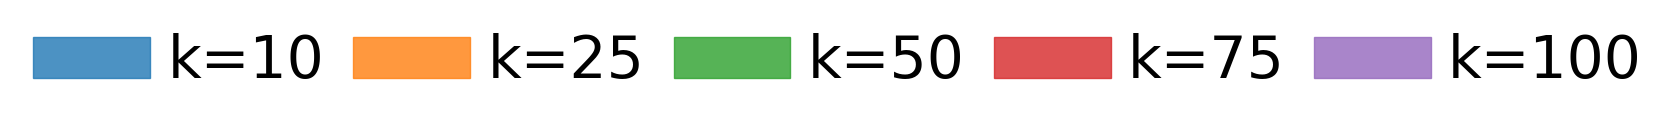

KeyError: 'T2I100M'

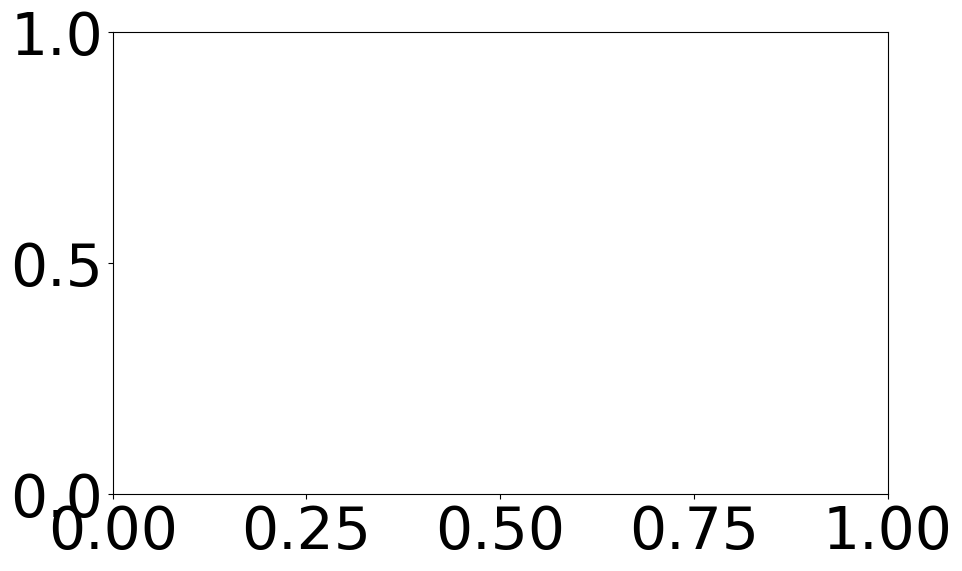

In [8]:
# Calculate for all datasets and all k-s the average recall vs the target recall
all_datasets = ["T2I100M"]
all_k_values = ["10", "25", "50", "75", "100"]
all_r_targets = ["0.80", "0.85", "0.90", "0.95"]
bar_width = 0.17
alpha = 0.8

plt.rcParams.update({"font.size": 42})
k_colors = {
    "10": "#1f77b4",  # Blue
    "25": "#ff7f0e",  # Orange
    "50": "#2ca02c",  # Green
    "75": "#d62728",  # Red
    "100": "#9467bd"  # Purple
}

fig_legend, ax_legend = plt.subplots(figsize=(8, 1))
legend_elements = [Patch(facecolor=k_colors[k], edgecolor=k_colors[k], alpha=0.8, label=f"k={k}") for k in ["10", "25", "50", "75", "100"]]
ax_legend.legend(handles=legend_elements, loc='center', ncol=5, frameon=False, handletextpad=0.3,  columnspacing=0.5, labelspacing=0.3 )
ax_legend.axis('off')
filename = f"{PLOTS_DIR}summary_speedups_legend_only_k_bars.pdf"
fig_legend.savefig(filename, bbox_inches="tight")
print(f"Fig saved at {filename}")
plt.show()
plt.close(fig_legend)

for ds_name in all_datasets:
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(all_r_targets))
    
    for i, k in enumerate(all_k_values):
        x_positions = x + i * bar_width
        recalls = []
        for j, r_target in enumerate(all_r_targets):
            if ds_name == "T2I100M" and r_target == "0.99":
                continue
            recall = ds_recalls[k][ds_name][j][0]
            recall_std = ds_recalls[k][ds_name][j][1]
            recalls.append(recall)
            ax.bar(x_positions[j], recall, bar_width, 
                   label=f"k={k}" if j == 0 and k in {"10", "25"} else "", 
                   color=k_colors[k], alpha=alpha, edgecolor='black', linewidth=1)
        
    ax.set_xticks(x + (len(all_k_values) - 1) * bar_width / 2)
    ax.set_yticks([0.80, 0.85, 0.90, 0.95, 0.99])
    ax.set_xlabel(r"$R_t$")
    ax.set_ylabel("Actual Recall")
    ax.set_xticklabels([str(t) for t in all_r_targets])
    #ax.tick_params(axis='x', labelsize=38)
    ax.grid(alpha=0.8, axis='y', linestyle='--')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_ylim(0.78, 1.00)
    
    fig.tight_layout()
    filename = f"{PLOTS_DIR}summary_recall_vs_target_recall_ds{ds_name}.pdf"
    fig.savefig(filename, bbox_inches='tight')
    print(f"Fig saved at {filename}")
    plt.show()
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    max_speedup = -1
    for i, k in enumerate(all_k_values):
        x_positions = x + i * bar_width
        speedups = []
        for j, r_target in enumerate(all_r_targets):
            if ds_name == "T2I100M" and r_target == "0.99":
                continue
            speedup = ds_recalls[k][ds_name][j][4]
            max_speedup = max(max_speedup, speedup)
            speedups.append(speedup)
            ax.bar(x_positions[j], speedup, bar_width, 
                   label=f"k={k}" if j == 0 and k in {"50", "75", "100"} else "", 
                   color=k_colors[k], alpha=alpha, edgecolor='black', linewidth=1)
        
    ax.set_xticks(x + (len(all_k_values) - 1) * bar_width / 2)
    ax.set_xlabel(r"$R_t$")
    ax.set_ylabel("Times Faster")
    ax.set_yticks(np.arange(1, max_speedup + 1, 5))
    ax.set_ylim(bottom=1)
    ax.set_xticklabels([str(t) for t in all_r_targets])
    ax.grid(alpha=0.8, axis='y', linestyle='--')
    #ax.tick_params(axis='x', labelsize=38)
    for spine in ax.spines.values():
        spine.set_visible(False)
    filename = f"{PLOTS_DIR}summary_speedup_vs_target_recall_ds{ds_name}.pdf"
    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    print(f"Fig saved at {filename}")
    
    plt.show()
    plt.close(fig)


## Analysis of the results of our Early Termination Method

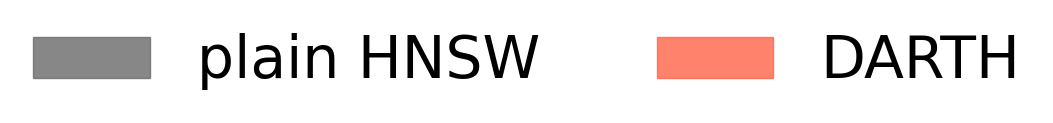

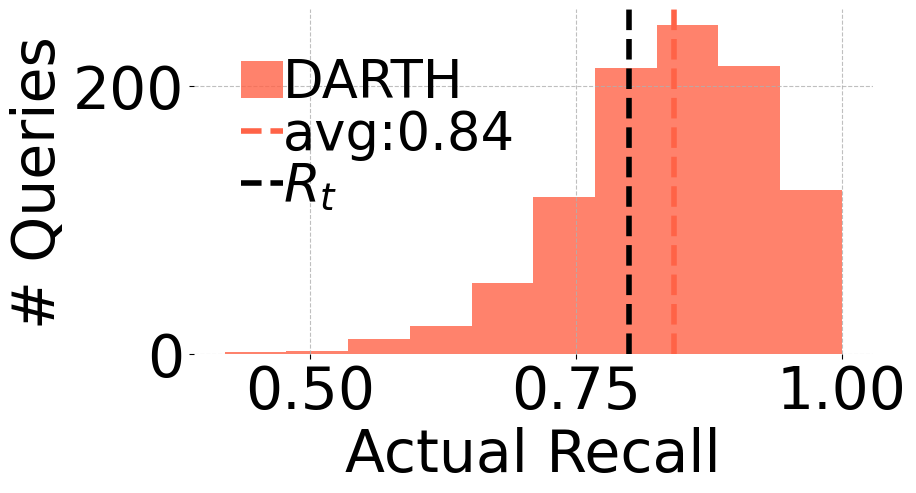

Speedup for DARTH:  4.502890340474329


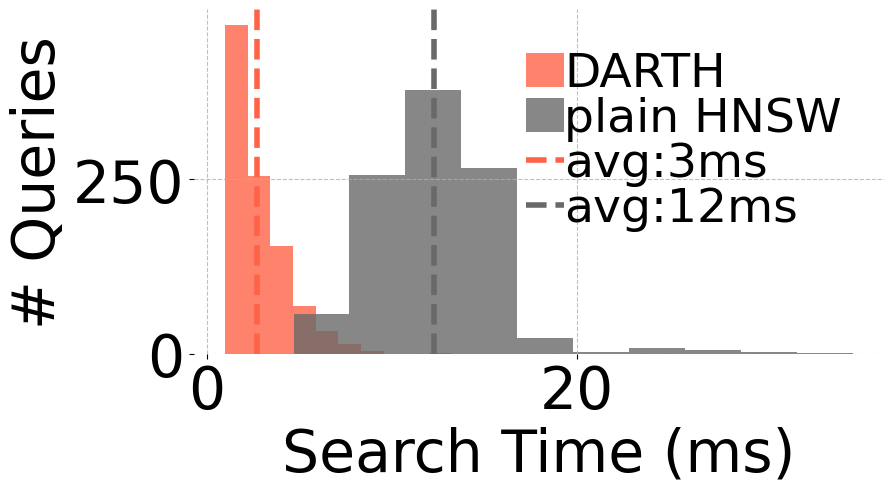

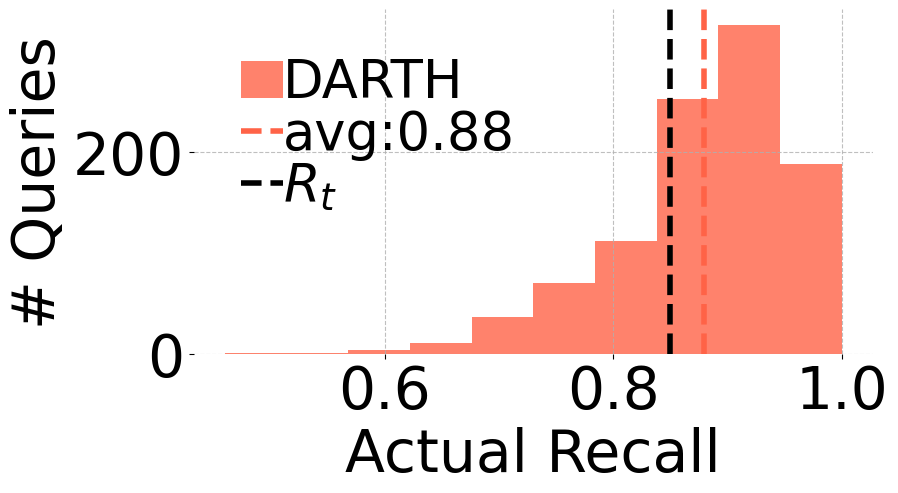

Speedup for DARTH:  3.709333040250657


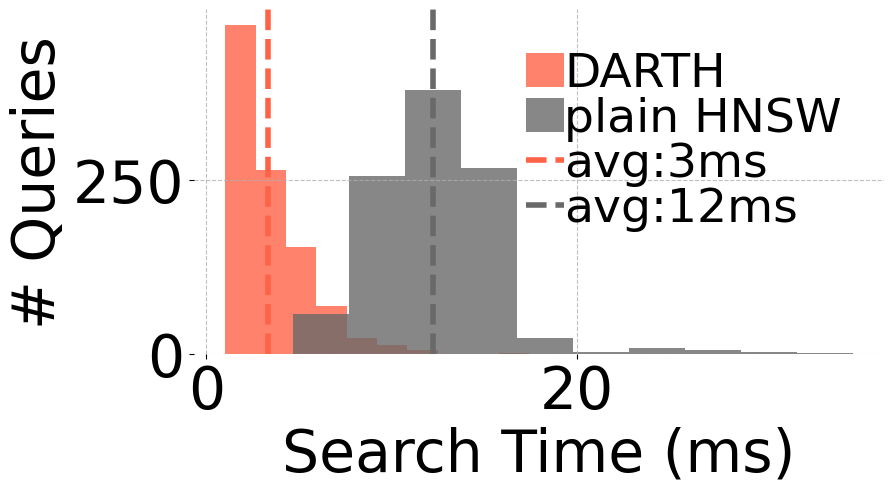

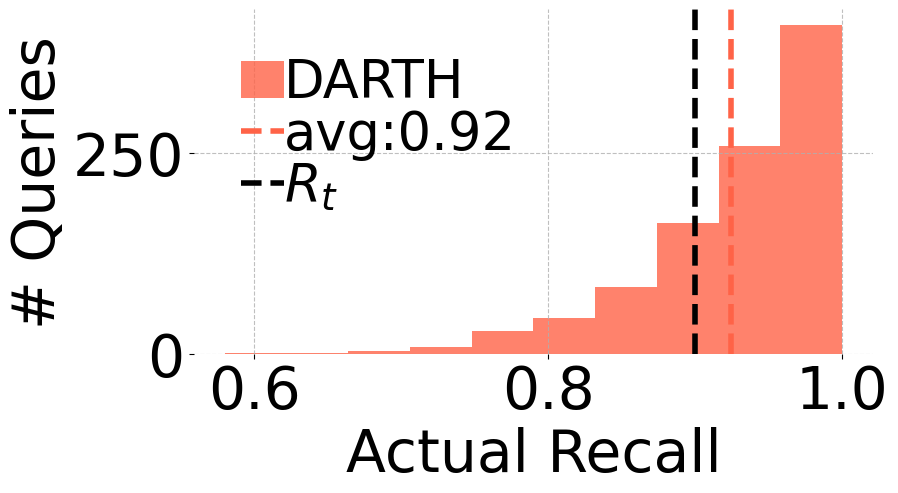

Speedup for DARTH:  2.95315360277707


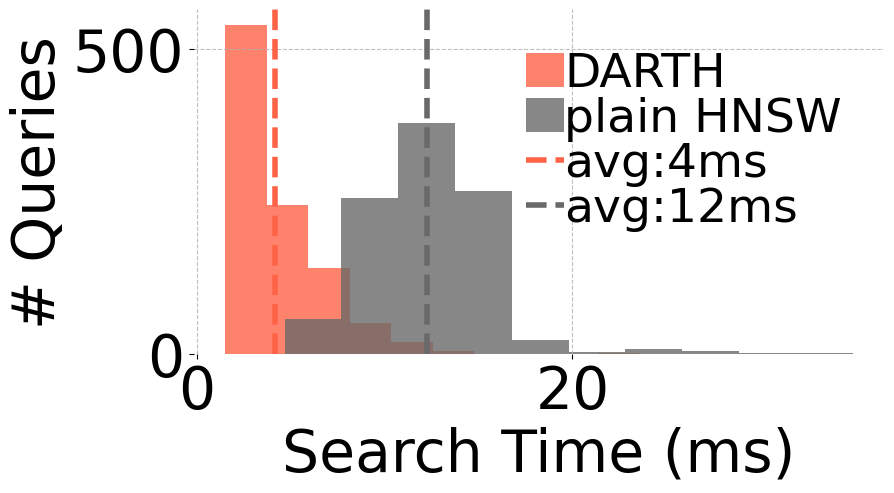

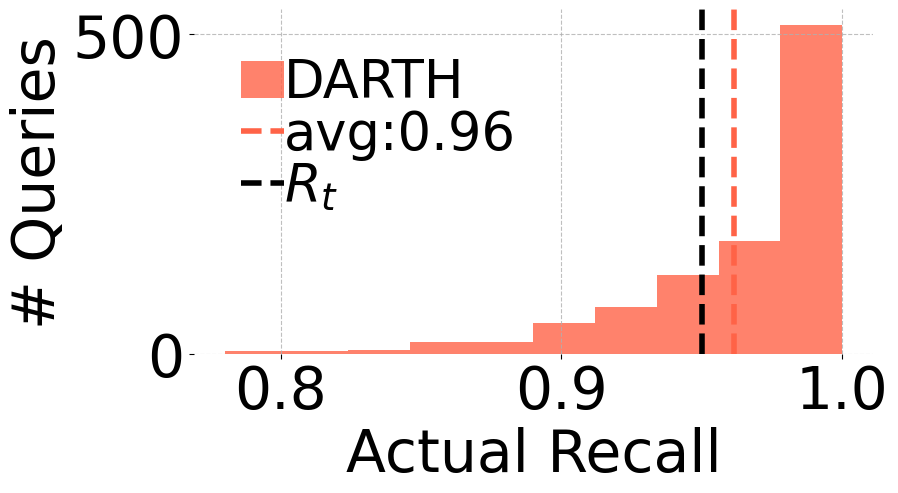

Speedup for DARTH:  2.1033421528790996


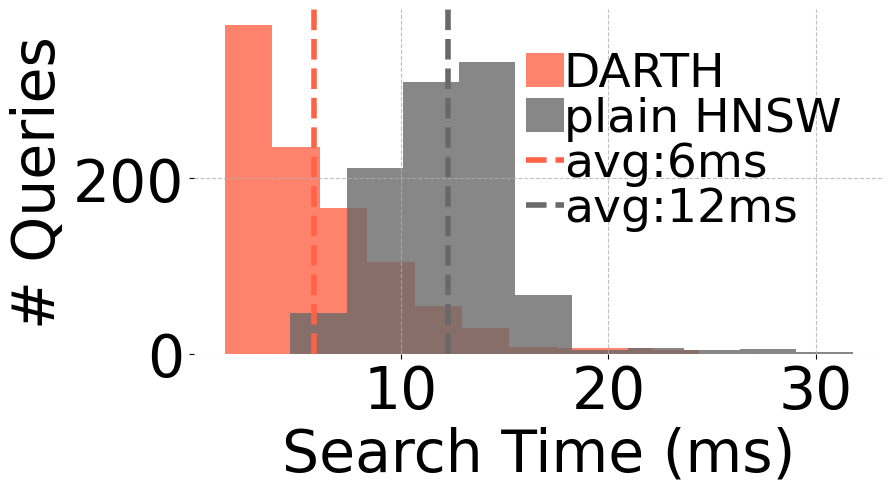

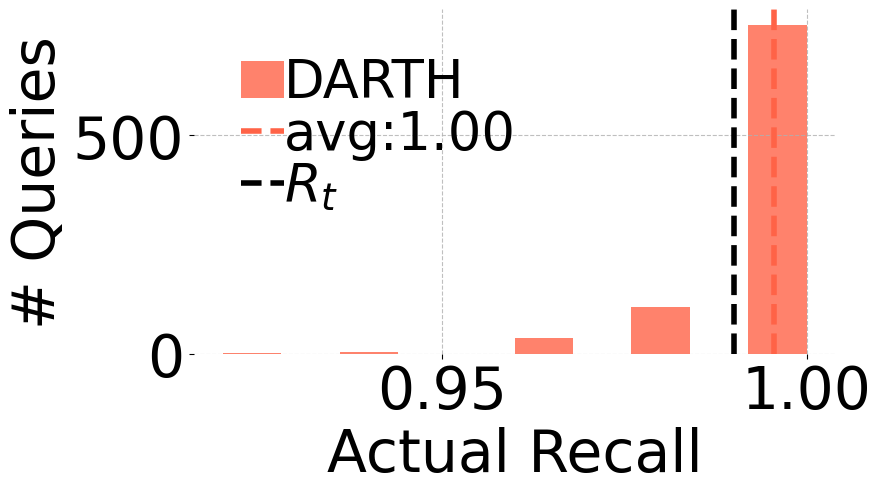

Speedup for DARTH:  1.3803273194134809


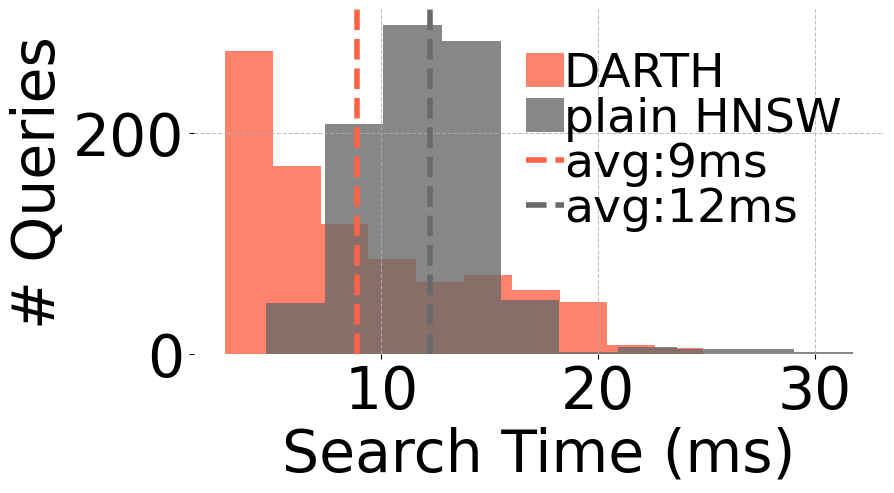

In [9]:
plt.rcParams.update({"font.size": 42}) 

fig_legend, ax_legend = plt.subplots(figsize=(8, 1))  # Adjust the figsize for better alignment
legend_elements = [
    Patch(facecolor="dimgray", edgecolor="dimgray", alpha=0.8, label="plain HNSW"),
    Patch(facecolor="tomato", edgecolor="tomato", alpha=0.8, label="DARTH"),
    #Line2D([0], [0], color="tomato", linestyle="dashed", linewidth=5, label="DARTH Avg."),
    #Line2D([0], [0], color="dimgray", linestyle="dashed", linewidth=5, label="HNSW No Early Termination Avg."),
    #Line2D([0], [0], color="black", linestyle="dashed", linewidth=5, label=r"$R_t$"), 
]
ax_legend.legend(handles=legend_elements, loc='center', ncol=5, frameon=False)

ax_legend.axis('off')
fig_legend.savefig(f"{PLOTS_DIR}perf_legend_only.pdf", bbox_inches="tight")
plt.show()
plt.close(fig_legend)

s = 1000
all_datasets = ["SIFT100M"]
all_k_values = ["50"]
for ds_name in all_datasets:
    for k in all_k_values:
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]
        r_targets = interval_conf[ds_name][k].keys()

        if ds_name == "T2I100M":
            r_targets = ["0.80", "0.85", "0.90", "0.95"]
        else:
            r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]

        for ir, r_target in enumerate(r_targets):
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
            r_target = float(r_target)
                        
            no_early_termination_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
            baseline_mean = no_early_termination_df["elaps_ms"].mean()
            darth_df = pd.read_csv(get_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target, ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            elapsed_mean = darth_df["elaps_ms"].mean()
            predictor_calls_mean = darth_df["r_predictor_calls"].mean()
            no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target]
            darth_df = darth_df[darth_df["qid"].isin(no_early_termination_df["qid"])]
            
            fig_recall, ax_recall = plt.subplots(figsize=(10, 6))
            ax_recall.hist(darth_df["r_actual"], alpha=0.8, color="tomato", linewidth=2.0, label="DARTH")
            r_actual_mean = darth_df["r_actual"].mean()
            ax_recall.axvline(r_actual_mean, color="tomato", linestyle="dashed", linewidth=4, label=f"avg:{r_actual_mean:.2f}")
            ax_recall.axvline(r_target, color="black", linestyle="dashed", linewidth=4, label=r"$R_t$")
            for spine in ax_recall.spines.values():
                spine.set_visible(False)
            ax_recall.set_ylabel("# Queries")
            ax_recall.set_xlabel(f"Actual Recall")
            ax_recall.grid(alpha=0.8, linestyle="--")
            ax_recall.legend(fontsize=38, handletextpad=0.0, columnspacing=0.0, labelspacing=0.0, frameon=False, handlelength=0.8)
            fig_recall.tight_layout()
            fig_recall.savefig(f"{PLOTS_DIR}perf_recall_{ds_name}_k{k}_{r_target}.pdf", bbox_inches="tight")
            plt.show()
            plt.close(fig_recall)
            
            #fig_predictor_calls, ax_predictor_calls = plt.subplots(figsize=(10, 6))
            #ax_predictor_calls.hist(darth_df["r_predictor_calls"], alpha=0.8, color="tomato", edgecolor="black", linewidth=2.0)
            #ax_predictor_calls.axvline(predictor_calls_mean, color="tomato", linestyle="dashed", linewidth=4, label=f"DARTH avg:{round(predictor_calls_mean)}")
            #for spine in ax_predictor_calls.spines.values():
            #    spine.set_visible(False)
            #ax_predictor_calls.set_ylabel("# Queries")
            #ax_predictor_calls.set_xlabel("Predictor Calls")
            #ax_predictor_calls.grid(alpha=0.8, linestyle="--")
            #ax_predictor_calls.legend(fontsize=24)
            #fig_predictor_calls.savefig(f"{PLOTS_DIR}perf_predictor_calls_{ds_name}_k{k}_{r_target}.pdf", bbox_inches="tight")
            #plt.show()
            #plt.close(fig_predictor_calls)

            fig_elapsed, ax_elapsed = plt.subplots(figsize=(10, 6))
            ax_elapsed.hist(darth_df["elaps_ms"], alpha=0.8, color="tomato", linewidth=2.0, label="DARTH")
            ax_elapsed.hist(no_early_termination_df["elaps_ms"], alpha=0.8, color="dimgray", linewidth=2.0, label="plain HNSW")
            elapsed_mean = darth_df["elaps_ms"].mean()
            print("Speedup for DARTH: ", baseline_mean / elapsed_mean)
            ax_elapsed.axvline(elapsed_mean, color="tomato", linestyle="dashed", linewidth=4, label=f"avg:{elapsed_mean:.0f}ms")
            ax_elapsed.axvline(baseline_mean, color="dimgray", linestyle="dashed", linewidth=4, label=f"avg:{baseline_mean:.0f}ms")
            for spine in ax_elapsed.spines.values():
                spine.set_visible(False)
            ax_elapsed.set_ylabel("# Queries")
            ax_elapsed.set_xlabel("Search Time (ms)")
            ax_elapsed.grid(alpha=0.8, linestyle="--")
            ax_elapsed.legend(fontsize=34, handletextpad=0.0, columnspacing=0.0, labelspacing=0.0, frameon=False, handlelength=0.8, loc="upper right")
            fig_elapsed.tight_layout()
            fig_elapsed.savefig(f"{PLOTS_DIR}perf_search_time_{ds_name}_k{k}_{r_target}.pdf", bbox_inches="tight")
            plt.show()
            plt.close(fig_elapsed)
            
            #fig_dists, ax_dists = plt.subplots(figsize=(8, 4))
            #ax_dists.hist(darth_df["dists"], alpha=0.7, color="tomato", edgecolor="black", linewidth=2.0)
            #ax_dists.hist(no_early_termination_df["dists"], alpha=0.7, color="dimgray", edgecolor="black", linewidth=2.0)
            #dists_mean = darth_df["dists"].mean()
            #baseline_dists_mean = no_early_termination_df["dists"].mean()
            #ax_dists.axvline(dists_mean, color="tomato", linestyle="dashed", linewidth=4, label=f"{dists_mean:.0f}")
            #ax_dists.axvline(baseline_dists_mean, color="dimgray", linestyle="dashed", linewidth=4, label=f"{baseline_dists_mean:.0f}")
            #for spine in ax_dists.spines.values():
            #    spine.set_visible(False)
            #ax_dists.set_ylabel("# Queries")
            #ax_dists.set_xlabel("Dists")
            #ax_dists.grid(alpha=0.7, linestyle="--")
            #ax_dists.legend()
            #fig_dists.savefig(f"./../../experiments/plots/perf_dists_{ds_name}_k{k}_{r_target}.pdf", bbox_inches="tight")
            #print(f"Fig saved at ./../../experiments/plots/perf_dists_{ds_name}_k{k}_{r_target}.pdf")
            #plt.show()
            #plt.close(fig_dists)
            

## [Probably to remove..] Rev. Proposal: Distribution of Distances for plain HNSW:


Fig saved at ./../../experiments/plots/plain_HNSW_dists_SIFT100M_k50.pdf


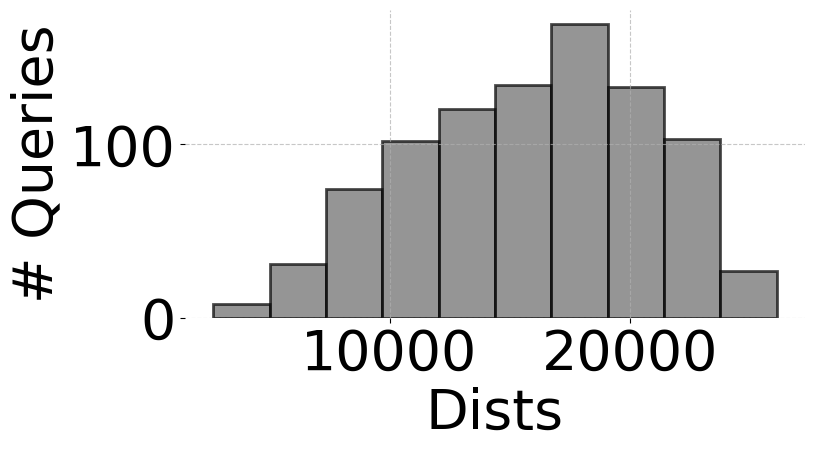

Fig saved at ./../../experiments/plots/plain_HNSW_dists_DEEP100M_k50.pdf


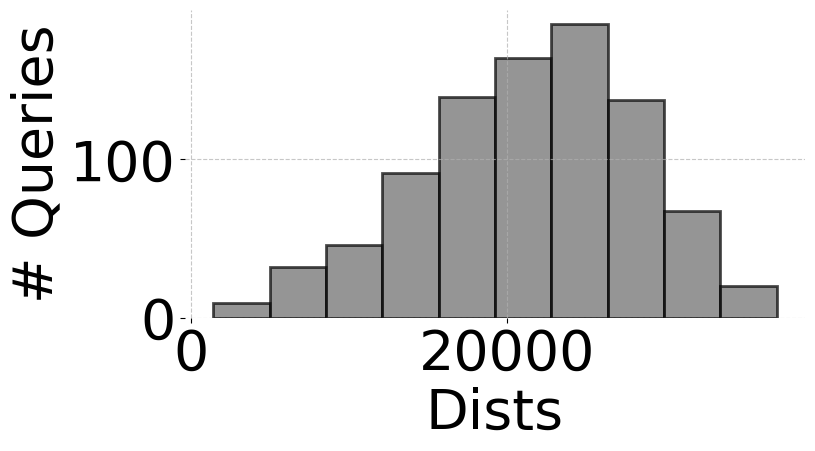

Fig saved at ./../../experiments/plots/plain_HNSW_dists_GLOVE100_k50.pdf


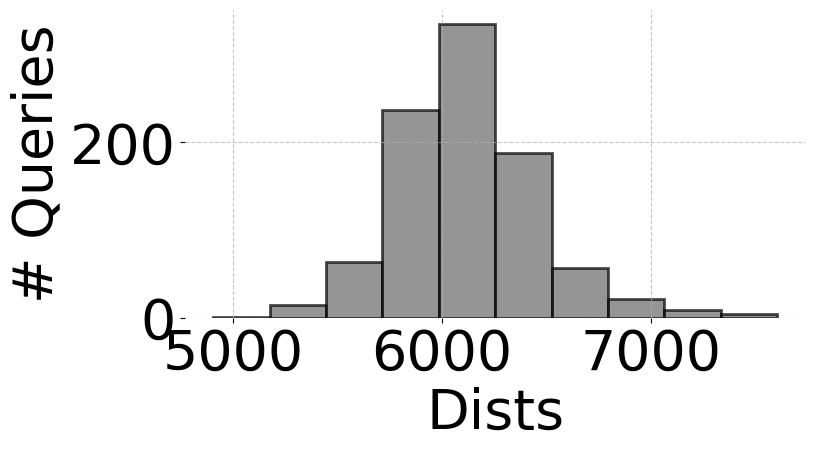

Fig saved at ./../../experiments/plots/plain_HNSW_dists_GIST1M_k50.pdf


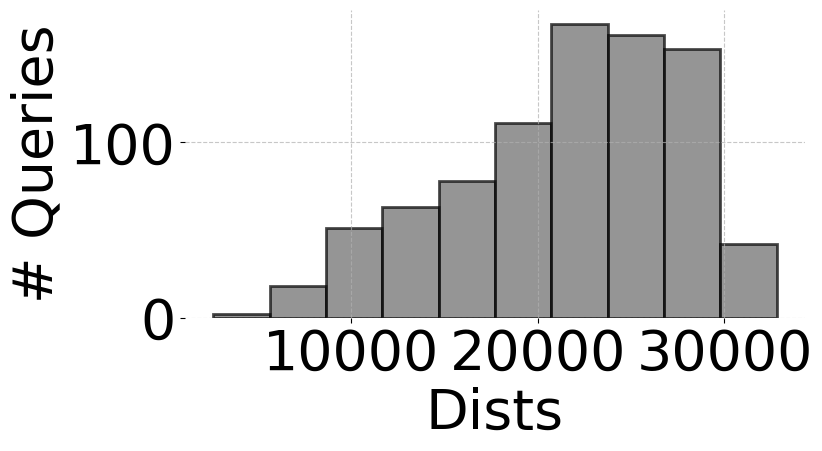

In [10]:
plt.rcParams.update({"font.size": 40}) 

s = 1000
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]#, "GLOVE100", "GIST1M"]
all_k_values = ["50"]
for ds_name in all_datasets:
    for k in all_k_values:
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]

        
        no_early_termination_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
        no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target]
            
        fig_dists, ax_dists = plt.subplots(figsize=(8, 4))
        ax_dists.hist(no_early_termination_df["dists"], alpha=0.7, color="dimgray", edgecolor="black", linewidth=2.0)
        for spine in ax_dists.spines.values():
            spine.set_visible(False)
        ax_dists.set_ylabel("# Queries")
        ax_dists.set_xlabel("Dists")
        ax_dists.grid(alpha=0.7, linestyle="--")
        fig_dists.savefig(f"./../../experiments/plots/plain_HNSW_dists_{ds_name}_k{k}.pdf", bbox_inches="tight")
        print(f"Fig saved at ./../../experiments/plots/plain_HNSW_dists_{ds_name}_k{k}.pdf")
        plt.show()
        plt.close(fig_dists)
        
        # Do the same for their recall
        #fig_recall, ax_recall = plt.subplots(figsize=(8, 4))
        #ax_recall.hist(no_early_termination_df["r"], alpha=0.7, color="dimgray", edgecolor="black", linewidth=2.0)
        #for spine in ax_recall.spines.values():
        #    spine.set_visible(False)
        #ax_recall.set_ylabel("# Queries")
        #ax_recall.set_xlabel("Recall")
        #ax_recall.grid(alpha=0.7, linestyle="--")
        #fig_recall.savefig(f"./../../experiments/plots/plain_HNSW_recall_{ds_name}_k{k}.pdf", bbox_inches="tight")
        #print(f"Fig saved at ./../../experiments/plots/plain_HNSW_recall_{ds_name}_k{k}.pdf")
        #plt.show()
        #plt.close(fig_recall)
            

## Analysis of the Errors of the DARTH approach

In [11]:
all_datasets = ["SIFT100M"] #"SIFT100M", "DEEP100M", "GLOVE100", "GIST1M", "T2I100M"]
all_k_values = ["100", "75", "50", "25", "10"]
all_r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]

# For the queries we surpassed the target recall, find how many distance calculations we did more than needed
# For the queries we did not reach the target recall, find how many distance calculations we needed to do more.

ds_recalls = {} # k -> dataset -> [recall, std, qut, speedup for each r_target]

for k in all_k_values:
    ds_recalls[k] = {}
    print(f"k: {k}")
    for ds_name in all_datasets:
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]
        print(f"    Dataset: {ds_name}")
        ds_recalls[k][ds_name] = []
        
        for r_target in all_r_targets:
            if ds_name == "T2I100M" and r_target == "0.99":
                continue
            
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
            r_target_fl = float(r_target)
                
            #print(f"r_target: {r_target}, ipi: {ipi}, mpi: {mpi}")
                
            no_early_termination_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
            darth_df = pd.read_csv(get_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target_fl, ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            no_early_termination_detailed_df = pd.read_csv(get_optimal_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
                    
            # for each one of the target recalls, find the minimum dist calcs that we needed to do to reach that recall, and put it in a column named min_dists_XX where XX is the recall
            grouped_detailed_no_early_termination = no_early_termination_detailed_df.groupby("qid")
            for qid, group in grouped_detailed_no_early_termination:
                min_dists = group[group["r"] >= r_target_fl]["dists"].min()
                min_time = group[group["r"] >= r_target_fl]["elaps_ms"].min()
                no_early_termination_df.loc[no_early_termination_df["qid"] == qid, f"min_dists_{r_target}"] = min_dists
                no_early_termination_df.loc[no_early_termination_df["qid"] == qid, f"min_time_{r_target}"] = min_time
                #darth_df.loc[darth_df["qid"] == qid, f"min_dists_{r_target}"] = min_dists
            
            # Important:
            # For the given recall target, find which queries do not reach the target recall in general (from the no-early-termination runs)
            # Then, remove those queries from both the no-early-termination and the DARTH runs
            no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target_fl]
            darth_df = darth_df[darth_df["qid"].isin(no_early_termination_df["qid"])]
            
            # Merge darth and no_early_termination_df
            rename_dict = {
                "elaps_ms": "total_elaps_ms",
                "dists": "total_dists",
                "inserts": "total_inserts",
                "r": "total_r",
                "step": "total_step",
            }
            no_early_termination_df = no_early_termination_df.rename(columns=rename_dict)
            darth_df = darth_df.merge(no_early_termination_df, on="qid", how="inner")
            
            darth_queries_above_target = darth_df[darth_df["r_actual"] >= r_target_fl].copy()
            darth_queries_below_target = darth_df[darth_df["r_actual"] < r_target_fl].copy()
            
            # For the queries we surpassed the target recall, find how many distance calculations we did more than needed
            darth_queries_above_target["dists_diff"] = darth_queries_above_target["dists"] - darth_queries_above_target[f"min_dists_{r_target}"]
            
            # For the queries we did not reach the target recall, find how many distance calculations we needed to do more.
            darth_queries_below_target["dists_diff"] = darth_queries_below_target[f"min_dists_{r_target}"] - darth_queries_below_target["dists"]
            
            more_dists_than_needed_avg = darth_queries_above_target["dists_diff"].mean()
            less_dist_than_needed_avg = darth_queries_below_target["dists_diff"].mean()
            avg_distance_calculations = darth_df["total_dists"].mean()
            
            perc_more_dists_than_needed = 100*more_dists_than_needed_avg / avg_distance_calculations
            perc_less_dist_than_needed = 100*less_dist_than_needed_avg / avg_distance_calculations       
            
            print(f"        r_target: {r_target} - More dists than needed: {more_dists_than_needed_avg:.0f} ({perc_more_dists_than_needed:.0f}%), Less dists than needed: {less_dist_than_needed_avg:.0f} ({perc_less_dist_than_needed:.0f}%), Avg dist calcs: {avg_distance_calculations:.0f}")
        print()
    print()


k: 100
    Dataset: SIFT100M
        r_target: 0.80 - More dists than needed: 749 (5%), Less dists than needed: 1079 (7%), Avg dist calcs: 16496
        r_target: 0.85 - More dists than needed: 907 (5%), Less dists than needed: 1315 (8%), Avg dist calcs: 16496
        r_target: 0.90 - More dists than needed: 1354 (8%), Less dists than needed: 1537 (9%), Avg dist calcs: 16470
        r_target: 0.95 - More dists than needed: 2041 (12%), Less dists than needed: 1728 (11%), Avg dist calcs: 16346
        r_target: 0.99 - More dists than needed: 4801 (30%), Less dists than needed: 1360 (9%), Avg dist calcs: 15815


k: 75
    Dataset: SIFT100M
        r_target: 0.80 - More dists than needed: 705 (4%), Less dists than needed: 961 (6%), Avg dist calcs: 16496
        r_target: 0.85 - More dists than needed: 821 (5%), Less dists than needed: 1211 (7%), Avg dist calcs: 16496
        r_target: 0.90 - More dists than needed: 1229 (7%), Less dists than needed: 1537 (9%), Avg dist calcs: 16483
       

## Distance Calculation Optimality

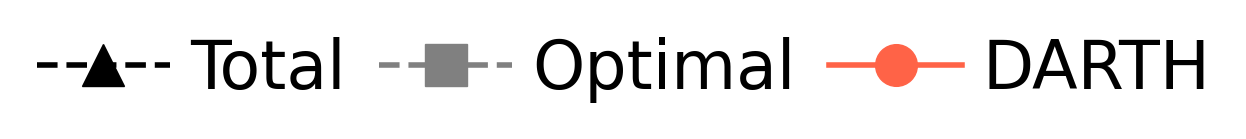

k: 50
Fig saved at ./../../experiments/revision-plots/enhanced_optimality_T2I100M_k50.pdf


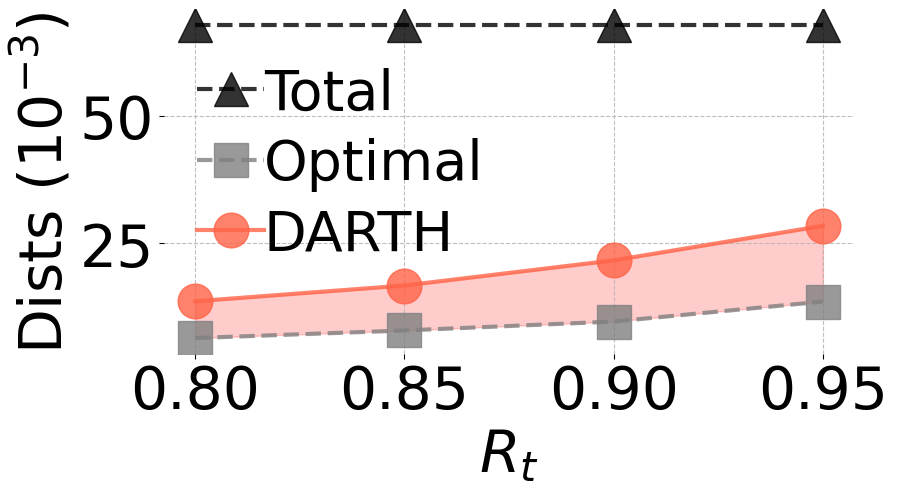

50: Average dist diff ratio: 0.15790604270038408
Average dist diff ratio: 0.15790604270038408


In [12]:
plt.rcParams.update({"font.size": 48})
fig_legend, ax_legend = plt.subplots(figsize=(8, 1))
legend_elements = [
    Line2D([0], [0], color="black", marker="^", linestyle="dashed", linewidth=4, label="Total", markersize=30),
    Line2D([0], [0], color="gray", marker="s",linestyle="dashed", linewidth=4, label="Optimal", markersize=30), 
    Line2D([0], [0], color="tomato", marker="o", linewidth=4, label="DARTH", markersize=30),
]
ax_legend.legend(
    handles=legend_elements, 
    loc='center', 
    ncol=3, 
    frameon=False, 
    handletextpad=0.3,  # Adjust padding between handle and text
    columnspacing=0.5,  # Adjust space between columns
    labelspacing=0.3    # Adjust vertical space between labels
)
ax_legend.axis('off')
filename = f"{PLOTS_DIR}optimality_legends_only.pdf"
fig_legend.savefig(filename, bbox_inches="tight")
plt.show()
plt.close(fig_legend)

all_datasets = ["T2I100M"]
all_k_values = ["50"]
all_r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]

# For the queries we surpassed the target recall, find how many distance calculations we did more than needed
# For the queries we did not reach the target recall, find how many distance calculations we needed to do more.

plt.rcParams.update({"font.size": 42})

average_dist_diffs = []
for k in all_k_values:
    print(f"k: {k}")
    
    average_dist_diffs_k = []
    for ds_name in all_datasets:
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]
        
        optimal_dists_per_r = []
        dists_by_DARTH_per_r = []
        total_dists_per_r = []
        
        if ds_name == "T2I100M":
            r_targets = ["0.80", "0.85", "0.90", "0.95"]
        else:
            r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]
        
        average_dist_diffs_k_r_target = []
        for r_target in r_targets:
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
            r_target_fl = float(r_target)
                                
            no_early_termination_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
            darth_df = pd.read_csv(get_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target_fl, ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            no_early_termination_detailed_df = pd.read_csv(get_optimal_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
                    
            # for each one of the target recalls, find the minimum dist calcs that we needed to do to reach that recall, and put it in a column named min_dists_XX where XX is the recall
            grouped_detailed_no_early_termination = no_early_termination_detailed_df.groupby("qid")
            for qid, group in grouped_detailed_no_early_termination:
                min_dists = group[group["r"] >= r_target_fl]["dists"].min()
                min_time = group[group["r"] >= r_target_fl]["elaps_ms"].min()
                no_early_termination_df.loc[no_early_termination_df["qid"] == qid, f"min_dists_{r_target}"] = min_dists
                no_early_termination_df.loc[no_early_termination_df["qid"] == qid, f"min_time_{r_target}"] = min_time
            
            total_dists_r_target = no_early_termination_df["dists"].mean()
            
            no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target_fl]
            darth_df = darth_df[darth_df["qid"].isin(no_early_termination_df["qid"])]
        
            optimal_dists_r_target = no_early_termination_df[f"min_dists_{r_target}"].mean()
            darth_dists_r_target = darth_df["dists"].mean()
        
            optimal_dists_per_r.append(optimal_dists_r_target)
            dists_by_DARTH_per_r.append(darth_dists_r_target)
            total_dists_per_r.append(total_dists_r_target)
            
            dist_diff_ratio = abs(darth_dists_r_target - optimal_dists_r_target) / total_dists_r_target
            average_dist_diffs_k_r_target.append(dist_diff_ratio)
        
        average_dist_diffs_k.append(np.mean(average_dist_diffs_k_r_target))
        
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(r_targets, [v / 1000 for v in total_dists_per_r], label="Total", color="black", marker="^", linestyle="--", markersize=25, linewidth=3, alpha=0.8)
        ax.plot(r_targets, [v / 1000 for v in optimal_dists_per_r], label="Optimal", color="gray", marker="s", linestyle="--", markersize=25, linewidth=3, alpha=0.8)
        ax.plot(r_targets, [v / 1000 for v in dists_by_DARTH_per_r], label="DARTH", color="tomato", marker="o", markersize=25, linewidth=3, alpha=0.8)
        
        # Add a red area between the optimal and DARTH lines
        ax.fill_between(r_targets, [v / 1000 for v in optimal_dists_per_r], [v / 1000 for v in dists_by_DARTH_per_r], color="red", alpha=0.2)
        
        ax.grid(alpha=0.8, linestyle="--")          
        ax.set_xlabel(r"$R_t$")
        ax.set_ylabel("Dists " + r"($10^{-3}$)")
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.legend(fontsize=40, frameon=False, loc="upper left", borderpad=0.1, bbox_to_anchor=(0.0, 0.93), handletextpad=0.0, columnspacing=0.5, labelspacing=0.3, handlelength=1.2)
        #ax.tick_params(axis='x', labelsize=44)
        fig.tight_layout()
        filename = f"{PLOTS_DIR}enhanced_optimality_{ds_name}_k{k}.pdf"
        fig.savefig(filename, bbox_inches='tight')
        print(f"Fig saved at {filename}")
        plt.show()
        plt.close(fig)
    
    print(f"{k}: Average dist diff ratio: {np.mean(average_dist_diffs_k)}")
    average_dist_diffs.append(np.mean(average_dist_diffs_k))

avg_dist_ratio = np.mean(average_dist_diffs)
print(f"Average dist diff ratio: {avg_dist_ratio}")

In [13]:
all_datasets = ["SIFT100M"]#["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M", "T2I100M"]
all_k_values = ["100", "75", "50", "25", "10"]
all_r_targets = ["0.80", "0.85", "0.90", "0.95", "0.99"]

# For the queries we surpassed the target recall, find how many distance calculations we did more than needed
# For the queries we did not reach the target recall, find how many distance calculations we needed to do more.



ds_recalls = {} # k -> dataset -> [recall, std, qut, speedup for each r_target]

for k in all_k_values:
    ds_recalls[k] = {}
    print(f"k: {k}")
    for ds_name in all_datasets:
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]
        print(f"    Dataset: {ds_name}")
        ds_recalls[k][ds_name] = []
        
        for r_target in all_r_targets:
            if ds_name == "T2I100M" and r_target == "0.99":
                continue
            
            ipi = interval_conf[ds_name][k][r_target]["ipi"]
            mpi = interval_conf[ds_name][k][r_target]["mpi"]
            r_target_fl = float(r_target)
                
            #print(f"r_target: {r_target}, ipi: {ipi}, mpi: {mpi}")
                
            no_early_termination_df = pd.read_csv(get_no_early_stop_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
            darth_df = pd.read_csv(get_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k, r_target_fl, ipi, mpi), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms",])
            no_early_termination_detailed_df = pd.read_csv(get_optimal_early_stop_testing_dataset_name(M, efC, efS, s, ds_name, k), usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r"])
                    
            # for each one of the target recalls, find the minimum dist calcs that we needed to do to reach that recall, and put it in a column named min_dists_XX where XX is the recall
            grouped_detailed_no_early_termination = no_early_termination_detailed_df.groupby("qid")
            for qid, group in grouped_detailed_no_early_termination:
                min_dists = group[group["r"] >= r_target_fl]["dists"].min()
                min_time = group[group["r"] >= r_target_fl]["elaps_ms"].min()
                no_early_termination_df.loc[no_early_termination_df["qid"] == qid, f"min_dists_{r_target}"] = min_dists
                no_early_termination_df.loc[no_early_termination_df["qid"] == qid, f"min_time_{r_target}"] = min_time
                #darth_df.loc[darth_df["qid"] == qid, f"min_dists_{r_target}"] = min_dists
            
            # Important:
            # For the given recall target, find which queries do not reach the target recall in general (from the no-early-termination runs)
            # Then, remove those queries from both the no-early-termination and the DARTH runs
            no_early_termination_df = no_early_termination_df[no_early_termination_df["r"] >= r_target_fl]
            darth_df = darth_df[darth_df["qid"].isin(no_early_termination_df["qid"])]
            
            # Merge darth and no_early_termination_df
            rename_dict = {
                "elaps_ms": "total_elaps_ms",
                "dists": "total_dists",
                "inserts": "total_inserts",
                "r": "total_r",
                "step": "total_step",
            }
            no_early_termination_df = no_early_termination_df.rename(columns=rename_dict)
            darth_df = darth_df.merge(no_early_termination_df, on="qid", how="inner")
            
            # total_dists, min_dists_{r_target}
            ratio_of_min_dists_to_total_dists = darth_df[f"min_dists_{r_target}"] / darth_df["total_dists"]
            avg_ratio = ratio_of_min_dists_to_total_dists.mean()
            print(f"        r_target: {r_target} - Avg ratio: {avg_ratio:.2f}")
            
        print()
    print()


k: 100
    Dataset: SIFT100M
        r_target: 0.80 - Avg ratio: 0.15
        r_target: 0.85 - Avg ratio: 0.19
        r_target: 0.90 - Avg ratio: 0.24
        r_target: 0.95 - Avg ratio: 0.32
        r_target: 0.99 - Avg ratio: 0.47


k: 75
    Dataset: SIFT100M
        r_target: 0.80 - Avg ratio: 0.13
        r_target: 0.85 - Avg ratio: 0.17
        r_target: 0.90 - Avg ratio: 0.22
        r_target: 0.95 - Avg ratio: 0.31
        r_target: 0.99 - Avg ratio: 0.49


k: 50
    Dataset: SIFT100M
        r_target: 0.80 - Avg ratio: 0.12
        r_target: 0.85 - Avg ratio: 0.15
        r_target: 0.90 - Avg ratio: 0.18
        r_target: 0.95 - Avg ratio: 0.27
        r_target: 0.99 - Avg ratio: 0.41


k: 25
    Dataset: SIFT100M
        r_target: 0.80 - Avg ratio: 0.09
        r_target: 0.85 - Avg ratio: 0.12
        r_target: 0.90 - Avg ratio: 0.15
        r_target: 0.95 - Avg ratio: 0.19
        r_target: 0.99 - Avg ratio: 0.28


k: 10
    Dataset: SIFT100M
        r_target: 0.80 - Avg ra